In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

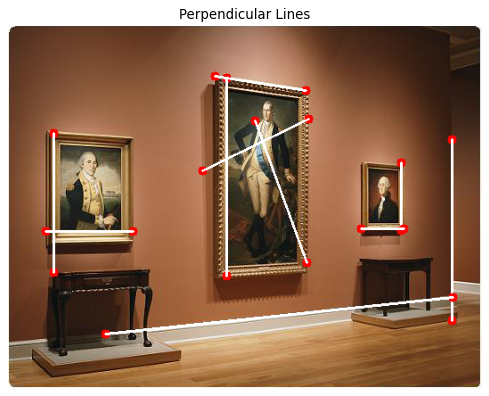

det(K) = 0.9794193434632501

K = [[0.98608251 0.16625667]
 [0.         0.99324279]]

v = [ 7.18108729e-04 -2.52433019e-05]

Η = [[ 9.96388985e-01  1.67994378e-01  0.00000000e+00]
 [ 0.00000000e+00  1.00362410e+00  0.00000000e+00]
 [ 7.25614358e-04 -2.55071433e-05  1.01045194e+00]]



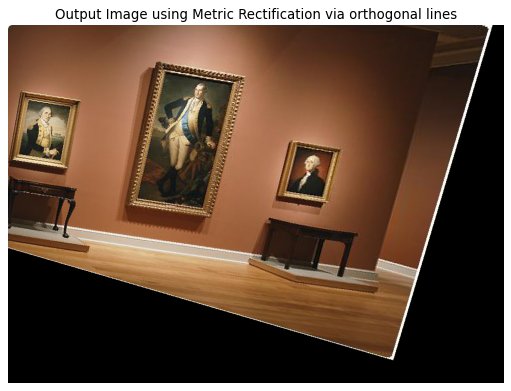

In [6]:
def find_line_equations(pts_1_line, pts_2_line):

    ### Convert points to homogenous coordinates ###
    if isinstance(pts_1_line, list):
        pts_1_line = np.array(pts_1_line)
    if pts_1_line.shape[1] != 3:
        pts_1_line = np.hstack((pts_1_line, np.ones((pts_1_line.shape[0], 1))))


    if isinstance(pts_2_line, list):
        pts_2_line = np.array(pts_2_line)
    if pts_2_line.shape[1] != 3:
        pts_2_line = np.hstack((pts_2_line, np.ones((pts_2_line.shape[0], 1))))

    lines = np.cross(pts_1_line, pts_2_line)
    lines = lines/lines[:, -1:]

    return lines


def prepare_system(perp_lines_1, perp_lines_2):

    ### As we concider f = 1, the system converts itno Ax = b, b = [-(l3[i]*m3[i])].T, i in {0, 4} ###

    A = np.zeros((perp_lines_1.shape[0], 5)) # a, b, c, d, e
    b = -1 * perp_lines_1[:, -1] * perp_lines_2[:, -1]  # -1(l3 * m3) as f=1

    A[:, 0] = perp_lines_1[:, 0] * perp_lines_2[:, 0]   # l1 * m1
    A[:, 1] = (perp_lines_1[:, 0] * perp_lines_2[:, 1] + perp_lines_1[:, 1] * perp_lines_2[:, 0])/2  # (l1 * m2 +l2 * m1)/2
    A[:, 2] = perp_lines_1[:, 1] * perp_lines_2[:, 1]  # l2 * m2
    A[:, 3] = (perp_lines_1[:, 0] * perp_lines_2[:, 2] + perp_lines_1[:, 2] * perp_lines_2[:, 0])/2  # (l1 * m3 +l3 * m1)/2
    A[:, 4] = (perp_lines_1[:, 1] * perp_lines_2[:, 2] + perp_lines_1[:, 2] * perp_lines_2[:, 1])/2  # (l2 * m3 +l3 * m2)/2

    return A, b


def find_conic(perp_lines_1, perp_lines_2):

    f = 1
    A, b = prepare_system(perp_lines_1, perp_lines_2)

    ### Solve the system ###
    C = np.linalg.pinv(A)@b # a:C[0], b:C[1], c:C[2], d:C[3], e:C[4]
    C_inf = np.array([[C[0], C[1]/2, C[3]/2],
                       [C[1]/2, C[2], C[4]/2],
                       [C[3]/2, C[4]/2, f]])

    C_inf = C_inf/np.amax(C_inf)

    return C_inf


def estimate_H(C_inf):
    
    ### Define K ###
    k22 = np.sqrt(C_inf[1][1])
    k12 = C_inf[0][1]/k22
    k11 = np.sqrt(C_inf[0][0]-(k12**2))
    
    K = np.array([[k11, k12],
                  [0, k22]])
    
    print(f"det(K) = {np.linalg.det(K)}\n")
    print(f"K = {K}\n")

    ### Define v ###
    v = np.linalg.inv(K@K.T)@C_inf[2][:2]
    print(f"v = {v}\n")
    
    ### Define u = 1 ###
    u = 1

    Ha = np.array([[k11, k12, 0],
                   [0  , k22, 0],
                   [0  , 0  , 1]])/np.sqrt(k11*k22)

    Hp = np.array([[1, 0, 0], 
                   [0, 1, 0], 
                   [v[0], v[1], u]])

    H = Ha@Hp

    print(f"Η = {H}\n")
    
    return H

def run(img_path, pts_1_line_1, pts_2_line_1, pts_1_line_2, pts_2_line_2):

    ### Find the line equation ###
    perp_lines_1 = find_line_equations(pts_1_line_1, pts_2_line_1)
    perp_lines_2 = find_line_equations(pts_1_line_2, pts_2_line_2)
    
    ### Find C_inf, solving the linear system Ax = b, concidering f as: f= 1
    C_inf = find_conic(perp_lines_1, perp_lines_2)

    ### Metric Rectification via orthogonal lines ###
    H = estimate_H(C_inf)

    ### Read img ###
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
       
    ### Apply inverse Homography ###
    out = cv2.warpPerspective(img, np.linalg.inv(H), (900, 650),flags=cv2. INTER_NEAREST)

    cv2.imwrite("Rectification_paintings.jpg", out)
    plt.figure(figsize=(8, 6), dpi=80)
    plt.imshow(out)
    plt.title("Output Image using Metric Rectification via orthogonal lines")
    plt.axis("off")
    plt.show()
    
if __name__ == "__main__" :

    img_path = 'paintings.jpg'

    img = cv2.imread(img_path)
    # Convert the img to grayscale
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # Apply edge detection method on the image
    edges = cv2.Canny(gray,50,150,apertureSize = 3)

    # This returns an array of r and theta values
    lines = cv2.HoughLinesP(
            edges,
            rho=2,              #Distance resolution of accumulator in pixels
            theta=np.pi / 180,  #Angle resolution of accumulator in radians
            threshold=100,      #Min. number of intersecting points to detect a line 
            lines=np.array([]), #Vector to return start and end points of the lines indicated by [x1, y1, x2, y2]
            minLineLength=40,   #Line segments shorter than this are rejected
            maxLineGap=25       #Max gap allowed between points on the same line
    )

    lines = np.squeeze(lines)
    # The below for loop runs till r and theta values 
    # are in the range of the 2d array
    pairs = [
            (8,159), 
             (151, 135),
             (39, 19),
             (4, 108),
             (145, 154)
            ]

    # Draw Lines on the image
    for i,j in pairs:
        line = lines[i]
        cv2.circle(img,(line[0],line[1]),5,255,-1)
        cv2.circle(img,(line[2],line[3]),5,255,-1)
        cv2.line(img,(line[0],line[1]),(line[2],line[3]),(255,255,255),2)
        line = lines[j]
        cv2.circle(img,(line[0],line[1]),5,255,-1)
        cv2.circle(img,(line[2],line[3]),5,255,-1)
        cv2.line(img,(line[0],line[1]),(line[2],line[3]),(255,255,255),2)

    # All the changes made in the input image are finally
    # written on a new image linesDetected.jpg
    cv2.imwrite("linesDetected.jpg", img)
    plt.figure(figsize=(8, 6), dpi=80)
    plt.imshow(img)
    plt.title('Perpendicular Lines')
    plt.axis("off")
    plt.show()    


    verticals = [8, 151, 39, 4, 145]
    horizontals = [159,135, 19, 108, 154]
    
    pts_1_line_1 = [] #list of 1st points of 1st perpendicular line
    pts_2_line_1 = [] #list of 2nd points of 1st perpendicular line
    pts_1_line_2 = [] #list of 1st points of 2st perpendicular line
    pts_2_line_2 = [] #list of 2nd points of 2st perpendicular line
    
    for indx, (i, j) in enumerate(zip(verticals, horizontals)):
        
        pts_1_line_1.append(lines[i][:2])
        pts_2_line_1.append(lines[i][2:])
        pts_1_line_2.append(lines[j][:2])
        pts_2_line_2.append(lines[j][2:])

    run(img_path, pts_1_line_1, pts_2_line_1, pts_1_line_2, pts_2_line_2)
